In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import os
from pathlib import Path
from sklearn.model_selection import train_test_split
from google.colab import drive
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
from concurrent.futures import ProcessPoolExecutor





In [4]:
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
df=pd.read_csv('/content/drive/My Drive/archive/bird_songs_metadata.csv')
df.head()


,id,genus,species,subspecies,name,recordist,country,location,latitude,longitude,altitude,sound_type,source_url,license,time,date,remarks,filename
0,557838,Thryomanes,bewickii,NaN,Bewick's Wren,Whitney Neufeld-Kaiser,United States,"Arlington, Snohomish County, Washington",48.0708,-122.1006,100,"adult, sex uncertain, song",//www.xeno-canto.org/557838,//creativecommons.org/licenses/by-nc-sa/4.0/,11:51,2020-03-14,"Recorded with Voice Record Pro on iPhone7, nor...",557838-0.wav
1,557838,Thryomanes,bewickii,NaN,Bewick's Wren,Whitney Neufeld-Kaiser,United States,"Arlington, Snohomish County, Washington",48.0708,-122.1006,100,"adult, sex uncertain, song",//www.xeno-canto.org/557838,//creativecommons.org/licenses/by-nc-sa/4.0/,11:51,2020-03-14,"Recorded with Voice Record Pro on iPhone7, nor...",557838-1.wav
2,557838,Thryomanes,bewickii,NaN,Bewick's Wren,Whitney Neufeld-Kaiser,United States,"Arlington, Snohomish County, Washington",48.0708,-122.1006,100,"adult, sex uncertain, song",//www.xeno-canto.org/557838,//creativecommons.org/licenses/by-nc-sa/4.0/,11:51,2020-03-14,"Recorded with Voice Record Pro on iPhone7, nor...",557838-4.wav
3,557838,Thryomanes,bewickii,NaN,Bewick's Wren,Whitney Neufeld-Kaiser,United States,"Arlington, Snohomish County, Washington",48.0708,-122.1006,100,"adult, sex uncertain, song",//www.xeno-canto.org/557838,//creativecommons.org/licenses/by-nc-sa/4.0/,11:51,2020-03-14,"Recorded with Voice Record Pro on iPhone7, nor...",557838-5.wav
4,557838,Thryomanes,bewickii,NaN,Bewick's Wren,Whitney Neufeld-Kaiser,United States,"Arlington, Snohomish County, Washington",48.0708,-122.1006,100,"adult, sex uncertain, song",//www.xeno-canto.org/557838,//creativecommons.org/licenses/by-nc-sa/4.0/,11:51,2020-03-14,"Recorded with Voice Record Pro on iPhone7, nor...",557838-6.wav


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5422 entries, 0 to 5421
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          5422 non-null   int64  
 1   genus       5422 non-null   object 
 2   species     5422 non-null   object 
 3   subspecies  1546 non-null   object 
 4   name        5422 non-null   object 
 5   recordist   5422 non-null   object 
 6   country     5422 non-null   object 
 7   location    5422 non-null   object 
 8   latitude    5332 non-null   float64
 9   longitude   5332 non-null   float64
 10  altitude    5380 non-null   object 
 11  sound_type  5422 non-null   object 
 12  source_url  5422 non-null   object 
 13  license     5422 non-null   object 
 14  time        5422 non-null   object 
 15  date        5422 non-null   object 
 16  remarks     3563 non-null   object 
 17  filename    5422 non-null   object 
dtypes: float64(2), int64(1), object(15)
memory usage: 762.6+ KB


In [7]:
df.describe()

,id,latitude,longitude
count,5422.000000,5332.000000,5332.000000
mean,292957.202139,36.938532,-101.548349
std,158950.516002,5.999919,18.099531
min,11713.000000,21.299500,-165.405300
25%,165291.000000,32.545800,-116.461000
50%,321905.000000,35.987000,-106.245900
75%,412669.000000,40.570000,-84.505200
max,565242.000000,64.503500,-68.375000


In [8]:
df['species'].unique()

array(['bewickii', 'polyglottos', 'migratorius', 'melodia', 'cardinalis'],
      dtype=object)

In [9]:
df['location'].nunique()

304

In [10]:
df['recordist'].unique()

array(['Whitney Neufeld-Kaiser', 'Bobby Wilcox', 'Steve Hampton',
       'Paul Marvin', 'Thomas G. Graves', 'bowtyler', 'Ed Pandolfino',
       'Frank Lambert', 'Richard E. Webster', 'Aidan Place', 'Sue Riffe',
       'Joshua Jaeger', 'Lance A. M. Benner', "Ryan P. O'Donnell",
       'Mouser Williams', 'Jim Holmes', 'Eric DeFonso', 'Tim Marquardt',
       'Jonathon Jongsma', 'Andrew Spencer', 'Tayler Brooks',
       'Chris Parrish', 'Michael S. Taylor', 'Phoenix Birder',
       'Brian Hendrix', 'David Robinson', 'ARUN PRABHU',
       'Matthew L. Brady', 'Pat Goltz', 'Rolf A. de By',
       'Barry Edmonston', 'Phil Brown', 'Matthew Vee',
       'Dominic Garcia-Hall', 'Brian Murphy', 'machyjakub', 'Diana Doyle',
       'Peter Boesman', 'Richard Dunn', 'Joshua Stevenson', 'Russ Wigh',
       'Mike Nelson', 'Matthias Feuersenger', 'Stuart Fisher',
       'Eric Zawatski', 'Jacob Saucier', 'Meena Haribal',
       'Nicholas Comparato', 'Gary Harbour', 'Jim Berry', 'Patrik Åberg',
       'Nick

In [11]:
df['genus'].unique()

array(['Thryomanes', 'Mimus', 'Turdus', 'Melospiza', 'Cardinalis'],
      dtype=object)

In [12]:
# Create a horizontal bar plot using Plotly
fig = go.Figure(go.Bar(
    x=df['species'].value_counts().sort_values(),
    y=df['species'].value_counts().sort_values().index,
    orientation='h',
    marker=dict(color='#3780BF')
))

fig.update_layout(title='Species Distribution', xaxis_title='Count', yaxis_title='Species')

fig.show()


In [14]:
fig = go.Figure(go.Bar(
    x=df['sound_type'].value_counts().sort_values(),
    y=df['sound_type'].value_counts().sort_values().index,
    orientation='h',
    marker=dict(color='#3780BF')
))

fig.update_layout(title='Sound Type Distribution', xaxis_title='Count', yaxis_title='Sound Type')

fig.show()


In [15]:
fig = go.Figure(go.Bar(
    x=df['location'].value_counts().sort_values(),
    y=df['location'].value_counts().sort_values().index,
    orientation='h',
    marker=dict(color='#3780BF')
))

fig.update_layout(title='Location Distribution', xaxis_title='Count', yaxis_title='Location')

fig.show()

In [16]:
# List for storing the filepaths and labels
file_paths = []
labels = []
audio_dir = '/content/drive/MyDrive/archive/wavfiles/'

for filename, species in df[['filename', 'species']].itertuples(index=False):
    file_path = Path(audio_dir) / filename
    if file_path.exists():
        file_paths.append(str(file_path))
        labels.append(species)
    else:
        print(f"File not found: {file_path}")

#first five elements of each list
print("First five file paths:", file_paths[:5])
print("First five labels:", labels[:5])


First five file paths: ['/content/drive/MyDrive/archive/wavfiles/557838-0.wav', '/content/drive/MyDrive/archive/wavfiles/557838-1.wav', '/content/drive/MyDrive/archive/wavfiles/557838-4.wav', '/content/drive/MyDrive/archive/wavfiles/557838-5.wav', '/content/drive/MyDrive/archive/wavfiles/557838-6.wav']
First five labels: ['bewickii', 'bewickii', 'bewickii', 'bewickii', 'bewickii']


In [18]:
def process_file(file_path, n_mels=128, hop_length=512, n_fft=2048):
    try:
        # Load audio file
        y, sr = librosa.load(file_path)

        # Compute Mel spectrogram
        mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, hop_length=hop_length, n_fft=n_fft)

        # Convert to log scale
        log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)

        return log_mel_spectrogram.flatten()
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

def extract_log_mel_spectrogram_features(file_paths, n_mels=128, hop_length=512, n_fft=2048):
    # Use parallel processing to speed up feature extraction
    with ProcessPoolExecutor() as executor:
        results = list(executor.map(process_file, file_paths, [n_mels] * len(file_paths), [hop_length] * len(file_paths), [n_fft] * len(file_paths)))

    # Filter out None results (errors during processing)
    log_mel_spectrogram_features = [result for result in results if result is not None]

    return np.array(log_mel_spectrogram_features)


X = extract_log_mel_spectrogram_features(file_paths, n_mels=50, hop_length=512, n_fft=2048)



In [19]:
# Check if labels are unique
if len(set(labels)) != len(labels):
    print("Warning: Duplicate labels detected!")

# Creating label dictionary using dictionary comprehension
label_dict = {label: index for index, label in enumerate(sorted(set(labels)))}

# Convert labels to numeric using the label dictionary
y = np.array([label_dict[label] for label in labels])

# Printing the first five elements of y
print("First five numeric labels:", y[:5])


First five numeric labels: [0 0 0 0 0]


In [20]:
# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(labels)


In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [22]:
# Initialize XGBoost classifier
model = XGBClassifier()

model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

In [23]:
# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.7944700460829494


In [25]:
#confusion Matrix
c = confusion_matrix(y_test, y_pred)
print(c)

[[141   6  42   3   1]
 [  4 164  20   6  10]
 [ 19   7 204   5   8]
 [  0   2  11 171  23]
 [  4  20  12  20 182]]


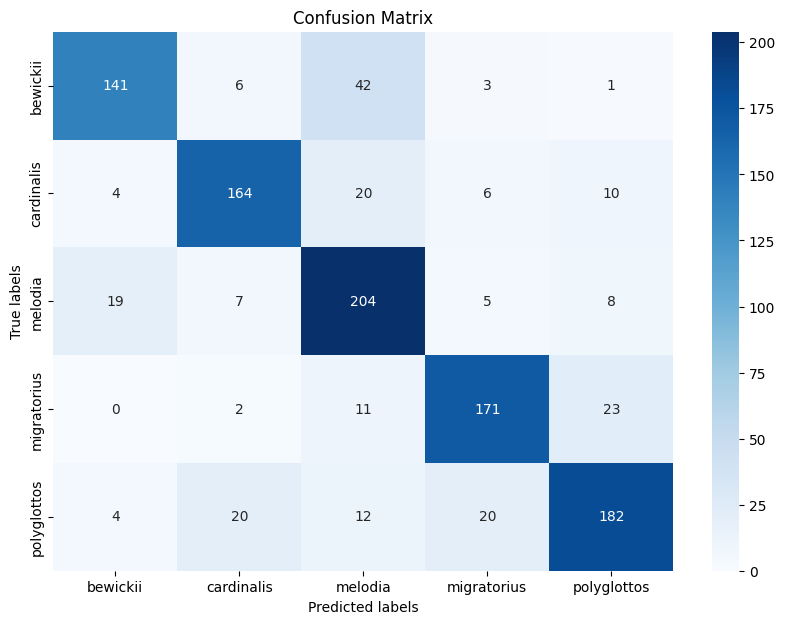

In [26]:
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [30]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.73      0.78       193
           1       0.82      0.80      0.81       204
           2       0.71      0.84      0.77       243
           3       0.83      0.83      0.83       207
           4       0.81      0.76      0.79       238

    accuracy                           0.79      1085
   macro avg       0.80      0.79      0.80      1085
weighted avg       0.80      0.79      0.79      1085

